In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [69]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) - z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))

# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.25, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# sim parameters
dt = 0.001
t_sim_init = 100
n_samples_init = int(t_sim_init/dt)
t_sim = 4000
n_samples = int(t_sim/dt)
upsamp = 10
t = np.linspace(0, t_sim, t_sim*upsamp)


# stim parameters
t_start = 100
Is1 = 2
Is2 = 5
I_duration = .3
I_inter = 5 - I_duration

ln_stim = np.array([5, 10, 15, 20, 30])#, 40, 50 #, 60, 70, 80, 100, 120, 140, 160, 200, 240, 300, 400, 500, 600]
llq, lte = [], []
for n_stim in ln_stim:
    print(n_stim)
    stim = 1

    # Fin initial conditions by root solving
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)
    
    for it in range(n_samples_init):
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

       
    lq = []
    for it in range(n_samples):
        # if it%10000==0:
        #     print(it)
        tc = it*dt
        if q[0]>-.5 and stim:
            stim = 0 # no stim after a seizure
            lte.append(tc*upsamp)
        elif stim==1 and it==n_samples-1:
            lte.append(t_sim*upsamp)
        
        tstim = 0
        if stim:
            for i_stim in range(n_stim):
                if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                    tstim = 1
        if tstim:
            parameters['Is1'] = Is1
            parameters['Is2'] = Is2
        else:
            parameters['Is1'] = 0
            parameters['Is2'] = 0
        
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

        if it%int(1/(upsamp*dt))==0:
            lq.append(q.copy())
    llq.append(lq)

llq = np.array(llq)

5
10
15
20
30


### Time series

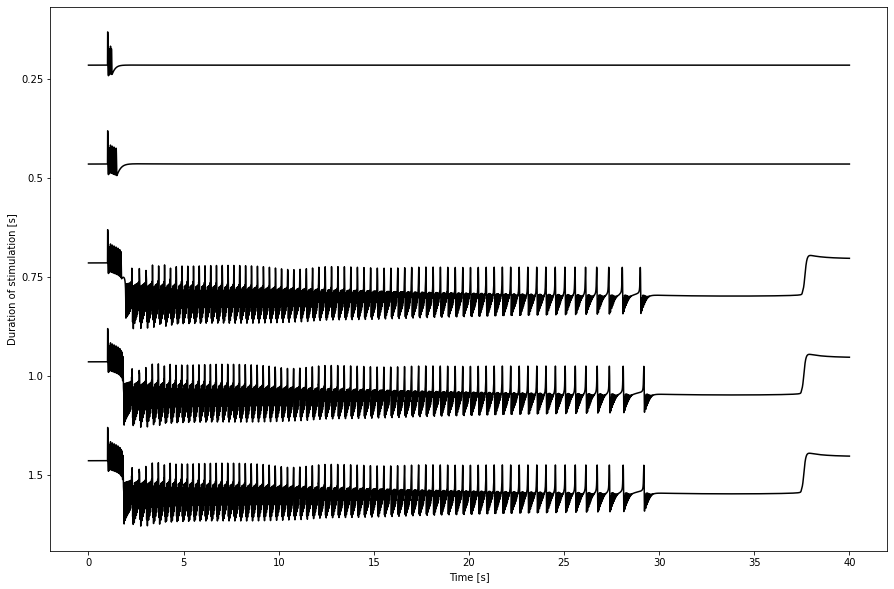

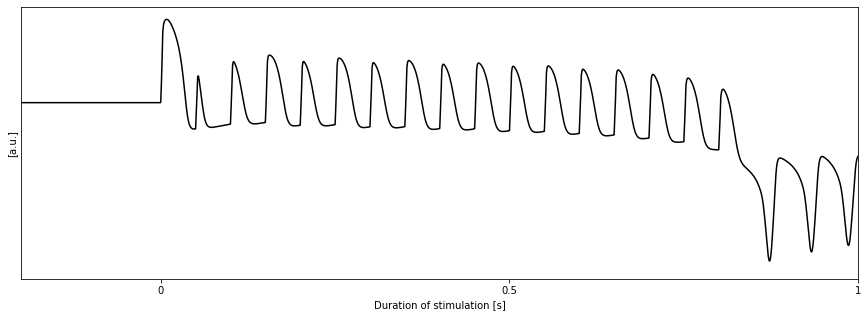

In [5]:
ts = -llq[:, :, 0] + llq[:, :, 3]
plt.figure(figsize=(15, 10))
for in_stim, n_stim in enumerate(ln_stim):
    # time in seconds
    plt.plot(t/100, ts[in_stim] - 5*in_stim, 'k')
# plt.xlim([0, 10])
plt.yticks(np.arange(0, -5*len(ln_stim), -5), (I_inter+.3)*np.array(ln_stim)/100)
plt.xlabel('Time [s]')
plt.ylabel('Duration of stimulation [s]')
plt.savefig('figures/train_stim_time_series.svg')

plt.figure(figsize=(15, 5))
# time in seconds
plt.plot(t/100, ts[4] - 5*4, 'k')
plt.xlim([0.8, 2.])
plt.xticks([1., 1.5, 2], [0, 0.5, 1])
plt.yticks([])
plt.xlabel('Duration of stimulation [s]')
plt.ylabel('[a.u.]')
plt.savefig('figures/train_stim_time_series_zoom.svg')